# jet.py demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import uproot
import awkward as ak
import jet

num_events = 100
channels = [
    "ZprimeToZhToZinvhbb",
    "ZprimeToZhToZlephbb",
    "QCD_HT1500to2000",
    "QCD_HT2000toInf",
]

data_path = "/Users/yianchen/CMS_Open_Data_Workspace/CMSSW_7_6_7/src/ZprimeToZh_VS_QCD/Analyzer/root_files/"

jet_events = []
fatjet_events = []
for i in range(len(channels)):
    channel = channels[i]
    root_file = f"{data_path}{channel}_{num_events}.root"
    uproot_file = uproot.open(root_file)
    events = uproot_file['jets/Events']
    jet_pt = jet.JetEvents(events, jet_type="jet", keep_by="pt")
    jet_events.append(jet_pt)
    fatjet_pt = jet.JetEvents(events, jet_type="fatjet", keep_by="pt")
    fatjet_events.append(fatjet_pt)

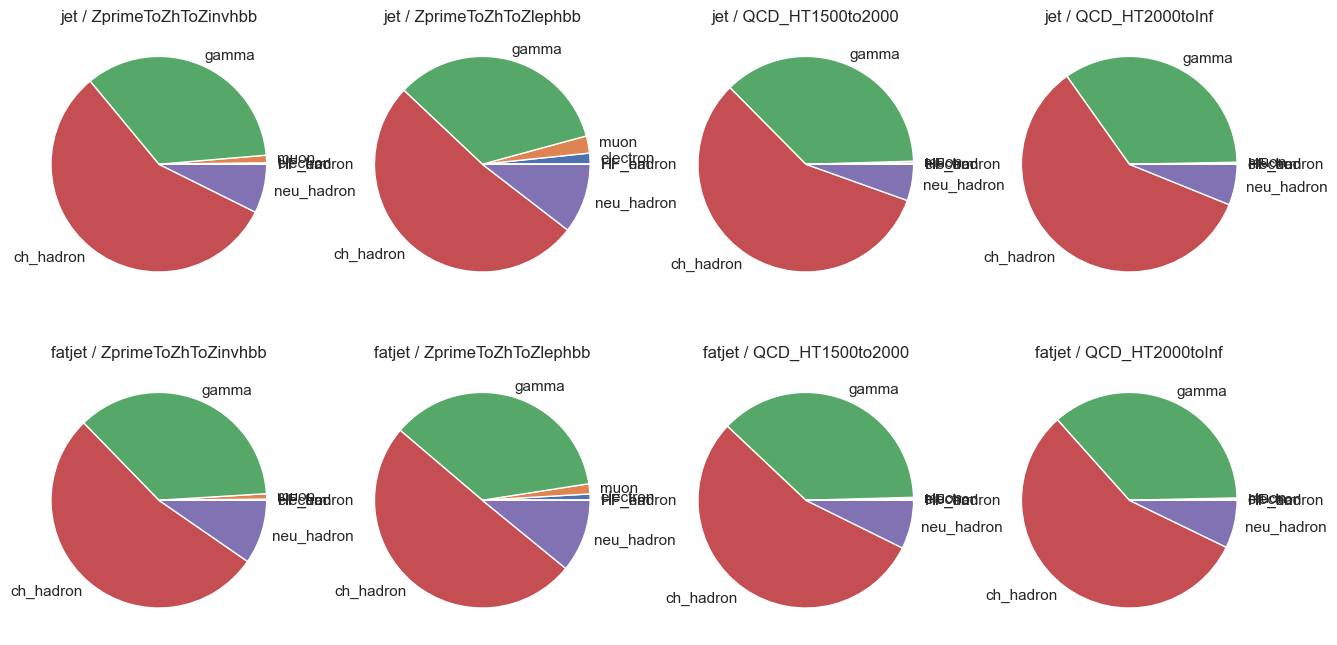

In [2]:
# draw the distribution of particles of jet and fatjet
fig, ax = plt.subplots(2, len(channels), figsize=(4*len(channels), 2*4), facecolor="white")

def draw_pie(events, ax):
    daughter = events.daughter
    ax.pie(
        x = [
            ak.sum(daughter["electron"]), ak.sum(daughter["muon"]), ak.sum(daughter["gamma"]),
            ak.sum(daughter["ch_hadron"]), ak.sum(daughter["neu_hadron"]),
            ak.sum(daughter["HF_hadron"]), ak.sum(daughter["HF_em"])
        ],
        labels = [
            "electron", "muon", "gamma",
            "ch_hadron", "neu_hadron", "HF_hadron", "HF_em"
            ]
    )

for i in range(len(channels)):
    draw_pie(jet_events[i], ax[0][i])
    draw_pie(fatjet_events[i], ax[1][i])
    ax[0][i].set_title(f"jet / {channels[i]}")
    ax[1][i].set_title(f"fatjet / {channels[i]}")

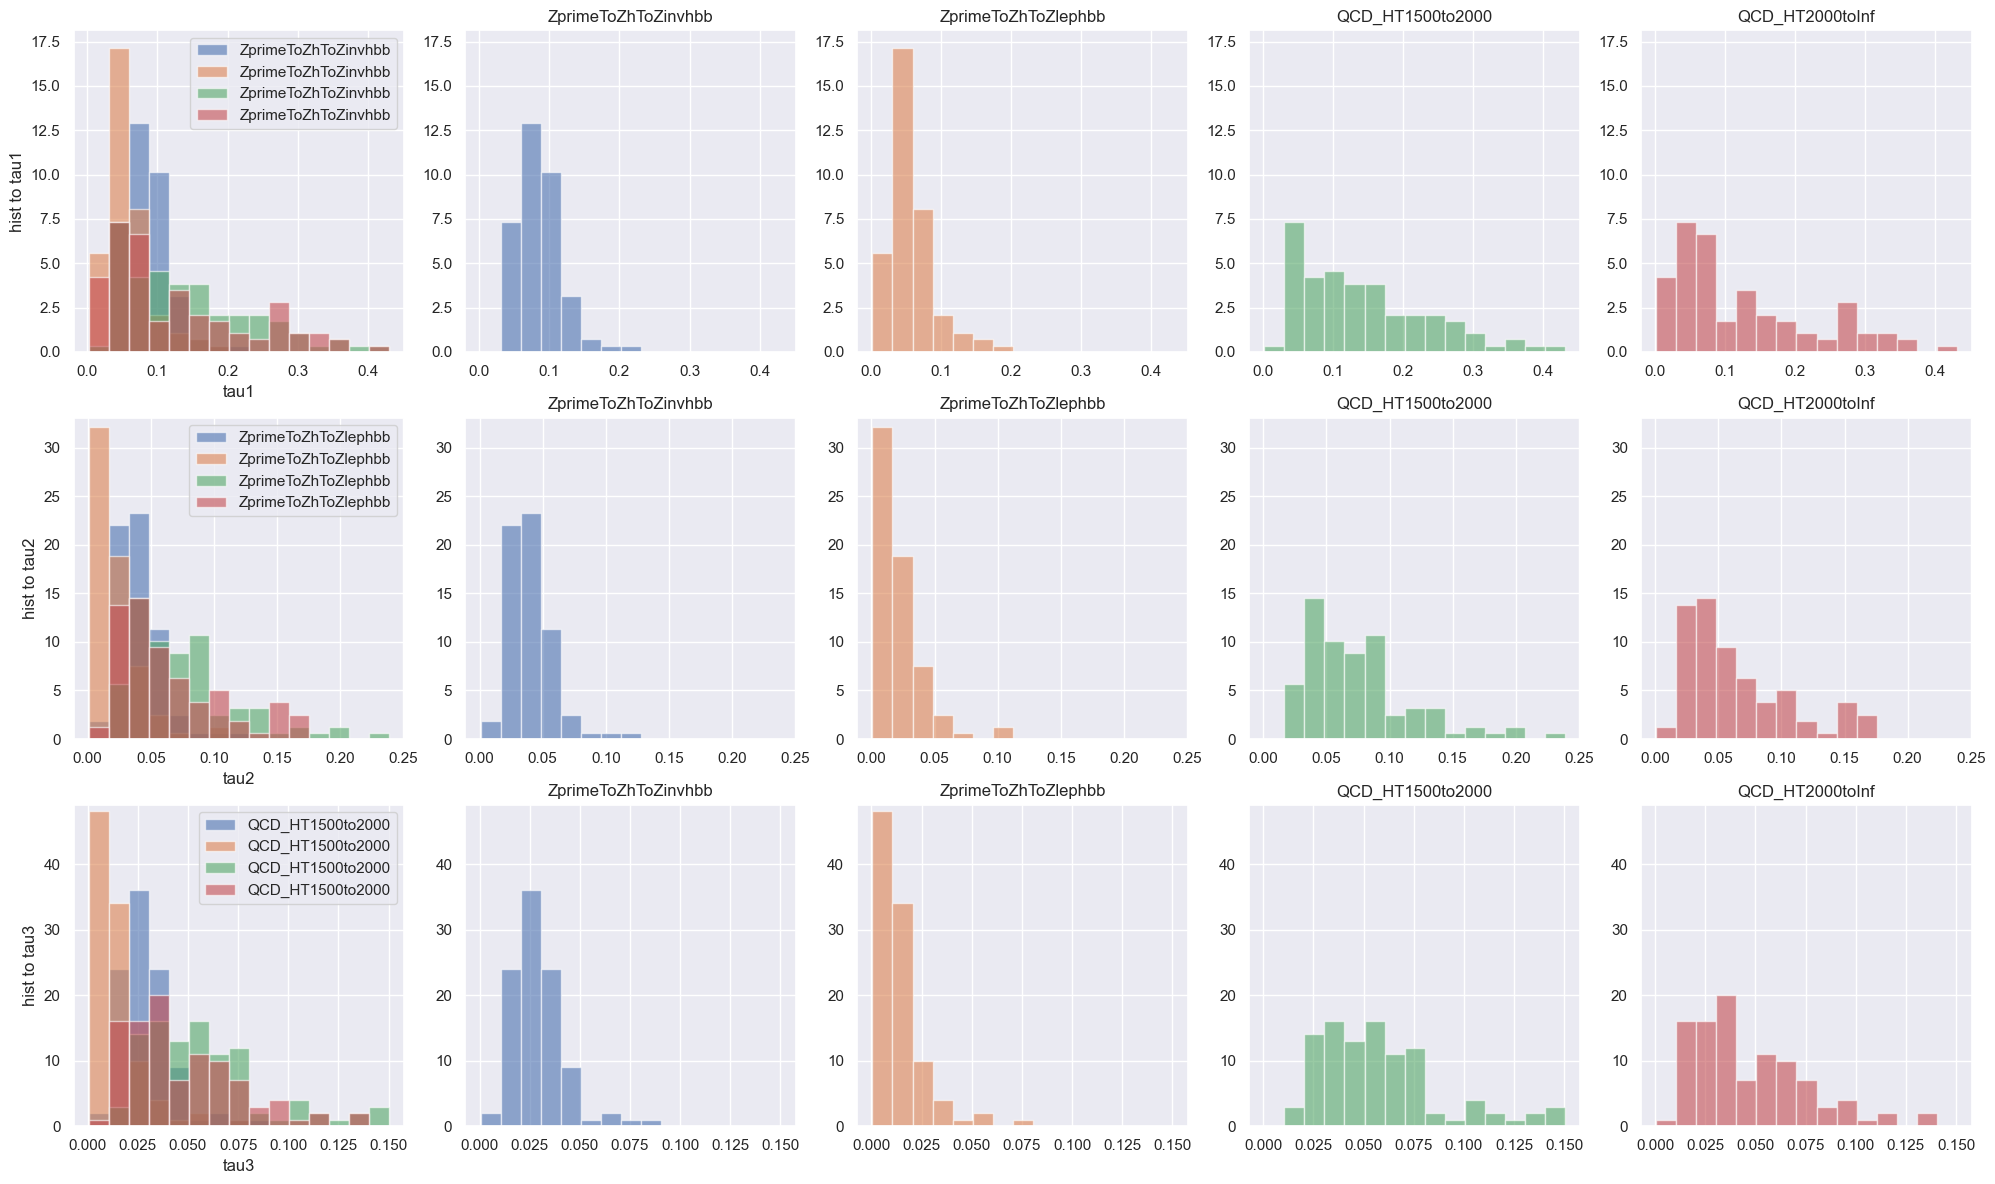

In [9]:
# draw n-subjettiness of fatjet
fig, ax = plt.subplots(3,len(channels)+1,figsize=((len(channels)+1)*4, 3*4))

tau_xrange, tau_yrange = {}, {"tau1":[0,0], "tau2":[0,0], "tau3":[0,0]}
for i in range(3):
    tau_xrange[f"tau{i+1}"] = [
        min([ak.min(events.nsubjettiness[f"tau{i+1}"]) for events in fatjet_events]),
        max([ak.max(events.nsubjettiness[f"tau{i+1}"]) for events in fatjet_events]),
    ]

for i in range(3):
    for j in range(len(channels)):
        events = fatjet_events[j]
        data = ak.to_numpy(events.nsubjettiness[f"tau{i+1}"])
        ax[i][j+1].hist(data, bins=15, label=channels[j], range=tau_xrange[f"tau{i+1}"], 
                        alpha=0.6, density=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
        pdf, _, _ = ax[i][0].hist(data, bins=15, label=channels[i], range=tau_xrange[f"tau{i+1}"], 
                        alpha=0.6, density=True)
        tau_yrange[f"tau{i+1}"][1] = max(tau_yrange[f"tau{i+1}"][1], max(pdf))

for i in range(3):
    tau_yrange[f"tau{i+1}"][1] += 1
    ax[i][0].set_xlabel(f"tau{i+1}")
    ax[i][0].set_ylabel(f"hist to tau{i+1}")
    ax[i][0].set_ylim(tau_yrange[f"tau{i+1}"])
    ax[i][0].legend()
    for j in range(len(channels)):
        ax[i][j+1].set_title(channels[j])
        ax[i][j+1].set_ylim(tau_yrange[f"tau{i+1}"])

plt.tight_layout()